In [ ]:
import nltk
# nltk.download('punkt_tab')
import sys
import os
import pandas as pd
# pip install keybert
from keybert import KeyBERT 
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
# pip install wordcloud
from wordcloud import WordCloud

keyword_model = KeyBERT('distilbert-base-nli-mean-tokens')
similarity_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [21]:
# loading and preprocessing articles
def get_articles_by_directory(directory):
    articles = []
    article_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                try:
                    with open(os.path.join(root, file), "r", errors="ignore") as f:
                        articles.append(f.read())
                        article_paths.append(os.path.join(root, file))
                except Exception as e:
                    print(f"Error reading file: {os.path.join(root, file)}\n{e}")
                    continue
    print(f"Loaded {len(articles)} articles in {directory}.")
    return articles, article_paths

def tokenize(articles):
    tokenized_articles = []
    for article in articles:
        try:
            tokenized_articles.append(nltk.sent_tokenize(article))
        except Exception as e:
            print(f"Tokenization error:\n{e}")
            continue
    # print(f"Tokenized {len(articles)} articles.")
    return tokenized_articles

def get_type(path):
    if "Presse" in path:
        return "Presse"
    elif "NGO" in path:
        return "NGO"
    elif "IGO" in path:
        return "IGO"
    assert False, f"Could not determine type of article: {path}"

def get_org(path):
    path = path.split("/")[-1] # remove everything before the last slash
    path = path.split("-")[0] # remove everything after the first hyphen
    return path

def generate_article_df(directory):
    articles, article_paths = get_articles_by_directory(directory)
    articles = tokenize(articles)
    articles = [" ".join(article) for article in articles]
    types = [get_type(path) for path in article_paths]
    orgs = [get_org(path) for path in article_paths]
    titles = [path.split("/")[-1] for path in article_paths]

    return pd.DataFrame({"title": titles, "article": articles, "type": types, "org": orgs})

def filter_df(df, type=None, org=None):
    if type is not None:
        df = df[df['type'] == type]
    if org is not None:
        df = df[df['org'] == org]
    print(f"Filtered to {len(df)} with type={type} and org={org}.")
    return df


In [8]:
# keyword extraction
def get_keywords_from_df(df, verbose=False, range=(1, 2), top_n=20, diversity=0.7):
    all_keywords = []
    i = 0
    for _, row in df.iterrows():
        i += 1
        sys.stdout.write("\rExtracting keywords... {}/{}".format(i, len(df)))
        sys.stdout.flush()
        keywords = keyword_model.extract_keywords(row['article'], keyphrase_ngram_range=range, stop_words='english', top_n=top_n, diversity=diversity)
        all_keywords.extend(keywords)

        if verbose:
            print(row['title'])
            for keyword, score in keywords:
                print(f"\t{keyword} ({round(score, 2)})")
    sys.stdout.write("\n")

    keywords_df = pd.DataFrame(all_keywords, columns=['Keyword', 'Score'])
    keyword_scores = keywords_df.groupby('Keyword').agg({'Score': 'sum'}).sort_values(by='Score', ascending=False)
    if verbose:
        print(keyword_scores.head(30))

    return keyword_scores
    

def group_similar_keywords(keywords, scores, cosine_similarities, threshold=0.85):
    grouped_keywords = []
    used_indices = set()
    
    for i, keyword in enumerate(keywords):
        sys.stdout.write("\rGrouping similar keywords... {}/{}".format(i+1, len(keywords)))
        sys.stdout.flush()
        if i in used_indices:
            continue
        grouped_keyword = {"keyword": keyword, "similar_keywords": [keyword], "scores": [scores[i]]}
        for j, score in enumerate(cosine_similarities[i]):
            if i != j and score > threshold:
                grouped_keyword["similar_keywords"].append(keywords[j])
                grouped_keyword["scores"].append(scores[j])
                used_indices.add(j)
        grouped_keyword["score_sum"] = round(sum(grouped_keyword["scores"]), 2)
        grouped_keywords.append(grouped_keyword)
    sys.stdout.write("\n")
    return grouped_keywords


def filter_keywords(keywords, min_score=1.0, max_keywords=100):
    filtered_keywords = [keyword for keyword in keywords if keyword["score_sum"] >= min_score]
    filtered_keywords = sorted(filtered_keywords, key=lambda x: x["score_sum"], reverse=True)[:max_keywords]
    print(f"Filtered keywords from {len(keywords)} to {len(filtered_keywords)}")
    return filtered_keywords

In [17]:
# visualization
def create_wordcloud(keyword_scores, title="", save=""):
    keyword_scores = {keyword['keyword']: keyword['score_sum'] for keyword in keyword_scores}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if title:
        plt.title(title)
    plt.axis('off')
    if save:
        plt.savefig(save)
    plt.show()


def create_bar_chart(keyword_scores, title="", save=""):
    keyword_scores = {keyword['keyword']: keyword['score_sum'] for keyword in keyword_scores}
    keywords, scores = zip(*keyword_scores.items())
    plt.figure(figsize=(10, 5))
    plt.barh(keywords, scores, color='skyblue')
    if title:
        plt.title(title)
    plt.xlabel('Relevance Score')
    plt.ylabel('Keywords')
    plt.gca().invert_yaxis()  # To display the highest score at the top
    if save:
        plt.savefig(save)
    plt.show()

# todo radar chart for comparison of individual keywords across article types
def create_radar_chart(keyword_scores, title):
    pass


In [42]:
articles_df = generate_article_df("COP/articles/by_org/")
presse_df = filter_df(articles_df, type="Presse")
presse_ft_df = filter_df(presse_df, type="Presse", org="FT")
presse_nyt_df = filter_df(presse_df, type="Presse", org="NYT")
presse_guardian_df = filter_df(presse_df, type="Presse", org="Guardian")
presse_usatoday_df = filter_df(presse_df, type="Presse", org="USAToday")
presse_telegraph_df = filter_df(presse_df, type="Presse", org="Telegraph")
igo_df = filter_df(articles_df, type="IGO")
ngo_df = filter_df(articles_df, type="NGO")
articles_df.head()

Loaded 1561 articles in COP/articles/by_org/.
Filtered to 1433 with type=Presse and org=None.
Filtered to 351 with type=Presse and org=FT.
Filtered to 377 with type=Presse and org=NYT.
Filtered to 269 with type=Presse and org=Guardian.
Filtered to 166 with type=Presse and org=USAToday.
Filtered to 270 with type=Presse and org=Telegraph.
Filtered to 47 with type=IGO and org=None.
Filtered to 81 with type=NGO and org=None.


,title,article,type,org
0,IPCC-2007-1.txt,A report of Working Group I of the Intergovern...,IGO,IPCC
1,IPCC-2007-2.txt,Climate Change 2007: Synthesis Report Summary ...,IGO,IPCC
2,IPCC-2007-3.txt,Contribution of Working Group II to the Fourth...,IGO,IPCC
3,IPCC-2007-4.txt,Contribution of Working Group III to the Fourt...,IGO,IPCC
4,REDD-2010-3.txt,Investing in REDD-plus Consensus Recommendati...,IGO,REDD


In [80]:
dfs = {"Presse": presse_df, "Presse FT": presse_ft_df, "Presse NYT": presse_nyt_df, "Presse Guardian": presse_guardian_df, "Presse USAToday": presse_usatoday_df, "Presse Telegraph": presse_telegraph_df, "IGO": igo_df, "NGO": ngo_df}
# current_df = "Presse"
current_df = "Presse FT"
# current_df = "Presse NYT"
# current_df = "Presse Guardian"
# current_df = "Presse USAToday"
# current_df = "Presse Telegraph"
# current_df = "IGO"
# current_df = "NGO"

In [81]:
# todo control keyword length
keywords = get_keywords_from_df(dfs[current_df])
keywords.head(30)

Extracting keywords... 351/351


,Score
Keyword,
climate change,96.2506
global warming,73.1329
barack obama,18.9878
obama,12.7222
climate scientists,10.5736
donald trump,7.6172
obama president,6.8791
mr obama,6.2910
news thursday,6.1767


In [82]:
embeddings = similarity_model.encode(keywords.index)
cosine_similarities_matrix = util.cos_sim(embeddings, embeddings) # ! optimize by only calculating upper triangle
grouped_keywords = group_similar_keywords(list(keywords.index), list(keywords['Score']), cosine_similarities_matrix)

Grouping similar keywords... 4911/4911


In [83]:
# ? create new keyword out of similar keywords or just use the highest scoring one?
filtered_keywords = filter_keywords(grouped_keywords, min_score=1.0, max_keywords=200)
for keyword in filtered_keywords:
    print(f"{keyword['keyword']}: {keyword['score_sum']}")
    #for similar_keyword, score in zip(keyword['similar_keywords'], keyword['scores']):
    #   print(f"\t{similar_keyword} ({score})")

Filtered keywords from 3873 to 200
climate change: 100.16
global warming: 74.77
barack obama: 53.36
climate scientists: 24.51
news thursday: 24.03
report climate: 19.61
climate policy: 16.91
climate crisis: 13.28
obama shortly: 13.06
achievements obama: 13.03
wednesday december: 11.82
thursday: 9.65
copenhagen summit: 9.4
donald trump: 9.27
climate initiative: 9.07
december 14: 9.06
debate climate: 8.57
thursday february: 8.22
tuesday november: 8.15
combating climate: 8.12
science climate: 7.6
obama office: 7.6
climate activists: 7.21
friday june: 6.85
devastating wildfires: 6.67
global climate: 6.36
climate physics: 6.3
tuesday: 6.13
obama administration: 6.05
flooding caused: 5.96
thursday july: 5.88
editor wednesday: 5.76
wednesday april: 5.73
cut emissions: 5.48
tuesday march: 5.46
2014 financial: 5.19
climate regulations: 5.19
copenhagen december: 5.05
coronavirus pandemic: 4.96
fossil fuels: 4.83
fix climate: 4.52
scientists: 4.51
increased flooding: 4.39
thursday january: 4.31
a

Filtered keywords from 3873 to 100


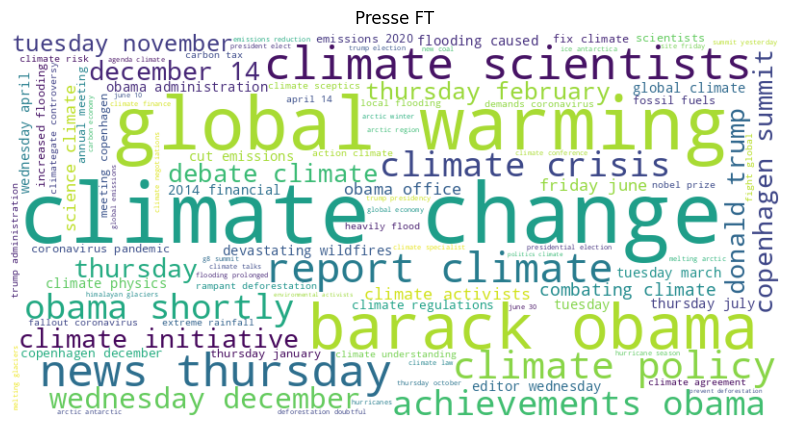

In [84]:
filtered_keywords = filter_keywords(grouped_keywords, min_score=1.0, max_keywords=100)
# create_wordcloud(filtered_keywords, "Presse")
create_wordcloud(filtered_keywords, title=current_df, save=f"COP/plots/keyword_analysis/wordcloud/{current_df}.png")

Filtered keywords from 3873 to 20


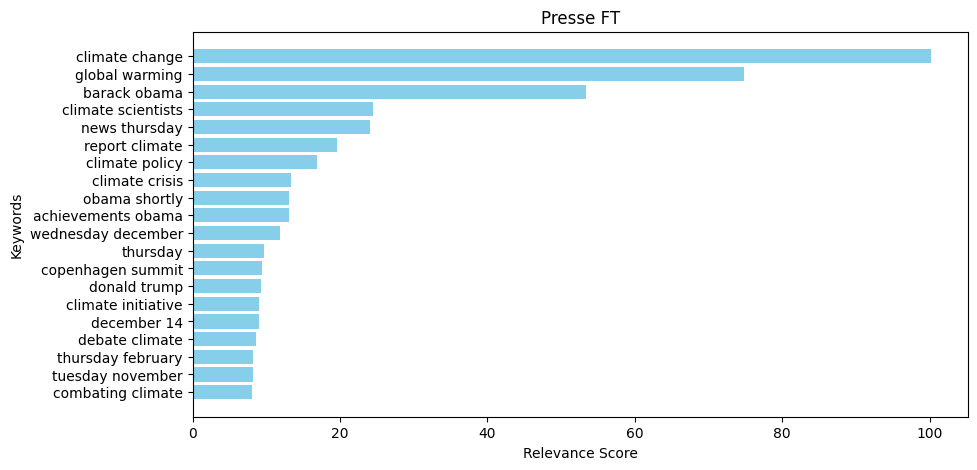

In [85]:
filtered_keywords = filter_keywords(grouped_keywords, min_score=1.0, max_keywords=20)
create_bar_chart(filtered_keywords, title=current_df, save=f"COP/plots/keyword_analysis/bar_chart/{current_df}.png")